Install Pytorch


In [ ]:
!pip3 install torch torchvision

# Inspecting the dataset


1.   Download the MNIST dataset
2.   Plot some images with their labels
3.   What kind of data is it?



Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!
Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
Dataset MNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test





/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


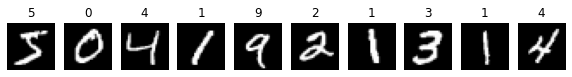

Min  0  Max  255


In [ ]:
import torch
from torchvision import datasets

downloaded_train = datasets.MNIST(root=".", train=True, download=True)
downloaded_test = datasets.MNIST(root=".", train=False, download=True)

print(downloaded_train)
print(downloaded_test)

# Inspect dataset
import matplotlib.pyplot as plt
samples = 10
plt.figure(figsize=(10, 15))
for i in range(samples):
    plt.subplot(1, samples, i+1)
    img = downloaded_train.data[i]
    label = downloaded_train.targets[i].item()
    plt.imshow(img, cmap="gray")
    plt.title(label)
    plt.axis("off")
plt.show()

# What are the min-max values? Does this tell us something about the data?
print("Min ", torch.min(downloaded_train.data).item(), " Max ", torch.max(downloaded_train.data).item())

# Preparing the dataset


1.   Convert grey-image values to 0-1 range
2.   Create an additional validation set from the training set
3.   Normalize the data by calculating mean and standard deviation from training set






In [ ]:
import torch
from torchvision import datasets

downloaded_train = datasets.MNIST(root=".", train=True, download=True)
downloaded_test = datasets.MNIST(root=".", train=False, download=True)

# Convert grey-image values to float
downloaded_train.data = 1.0*downloaded_train.data/255
downloaded_test.data = 1.0*downloaded_test.data/255

from sklearn.model_selection import train_test_split
# Split training into training and validation set
train_data, validation_data, train_targets, validation_targets = train_test_split(downloaded_train.data, downloaded_train.targets, test_size=10000)
test_data, test_targets = downloaded_test.data, downloaded_test.targets
# Check dimensions
print(train_data.shape, validation_data.shape, test_data.shape)

# Normalize all three datasets (using mean and std from only the training set)
# Also possible to use min-max scaling

# Calc mean and std from training set data
mean_train = torch.mean(train_data)
std_train = torch.std(train_data)
print(f"mean_train: {mean_train:.5f}, std_train: {std_train:.5f}")

# Normalize
train_data = (train_data - mean_train) / std_train
validation_data = (validation_data - mean_train) / std_train
test_data = (test_data - mean_train) / std_train

# (Sanity-check) Are they normalized now? (Mean should be 0 and Standard-deviation should be 1)
print()
print("Sanity-check: Mean should be 0 and Standard-deviation should be 1")
print(f"Train-data:      Mean: {torch.mean(train_data).item():.4f} Std: {torch.std(train_data).item():.4f}")
print(f"Validation-data: Mean: {torch.mean(validation_data).item():.4f} Std: {torch.std(validation_data).item():.4f}")
print(f"Test-data:       Mean: {torch.mean(test_data).item():.4f} Std: {torch.std(test_data).item():.4f}")

torch.Size([50000, 28, 28]) torch.Size([10000, 28, 28]) torch.Size([10000, 28, 28])
mean_train: 0.13048, std_train: 0.30800

Sanity-check: Mean should be 0 and Standard-deviation should be 1
Train-data:      Mean: 0.0003 Std: 1.0000
Validation-data: Mean: 0.0022 Std: 1.0022
Test-data:       Mean: 0.0066 Std: 1.0081




---


# Creating a PyTorch Dataset requires the following functions implemented:


*   \_\_init__(self, **params)
*   \_\_getitem__(self, idx)
*   \_\_len__(self)

Then use this class to create datasets from our data.


In [ ]:
from torch.utils.data import Dataset

# Create a dataset class that holds the data and targets
class MyMNISTdataset(Dataset):
    # Need to implement __init__(self, **params), __getitem__(self, idx), __len__(self)
    def __init__(self, data, targets):
        super(MyMNISTdataset, self)
        self.data = data
        self.targets = targets

    def __getitem__(self, idx):
        x = self.data[idx]
        target = self.targets[idx]
        return x, target

    def __len__(self):
        return len(self.targets)


train_dataset = MyMNISTdataset(train_data, train_targets)
validation_dataset = MyMNISTdataset(validation_data, validation_targets)
test_dataset = MyMNISTdataset(test_data, test_targets)

print("Datasets created!")

Datasets created!


Create dataloader with dataset

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Length train_dl: ", len(train_dl))
print("Length valid_dl: ", len(valid_dl))
print("Length test_dl: ", len(test_dl))

# What is the length of the dataloader?

Length train_dl:  782
Length valid_dl:  157
Length test_dl:  157




---

# The cool stuff begins:
### Creating the neural network

Simple network building with nn.Sequential()

For e.g. a Multilayer Perceptron

<img src="https://i.imgur.com/DGY97pw.png" height="250">

In [ ]:
from torch import nn

# Function to count (trainable) parameters in a model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = nn.Sequential(
                      nn.Linear(784, 64),
                      nn.ReLU(inplace=True),
                      nn.Linear(64, 32),
                      nn.ReLU(inplace=True),
                      nn.Linear(32, 10)
                    )
print("Parameters: ", count_parameters(model))

Parameters:  52650


### Or create a network class that implements:


*   \_\_init__(self, *params)
*   forward(self, x)



In [ ]:
from torch import nn
import torch.nn.functional as F

class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.input_layer = nn.Linear(784, 64)
        self.hidden_layer = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, 10)

    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        x = self.hidden_layer(x)
        x = F.relu(x)
        x = self.output_layer(x)
        return x

model = SimpleMLP()
print("Parameters: ", count_parameters(model))

Parameters:  52650


# Building the training loop:


1. Create model
2. Choose optimizer
3. Select appropriate loss function
4. Iterate through training dataloader:
  1. Feed data into model
  2. Compare true vs predicted value
  3. Backpropagate
5. Iterate through validation dataloader:
  1. Feed data into model
  2. Compare true vs predicted value
  3. Count correct predictions




In [ ]:
import time

model = SimpleMLP()
# model = MyCNN()
print("Parameters: ", count_parameters(model))

opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
for i in range(epochs):
    start_time = time.time()
    model.train()
    train_loss = 0.0
    for data, target in train_dl:
        y_pred = model(torch.flatten(data, 1))
        # y_pred = model(data)
        loss = loss_func(y_pred, target)

        # Do backpropagation
        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss += loss.item()
    train_loss /= len(train_dl)

    # Validate with valid_dl
    correct = 0.0
    valid_loss = 0.0
    model.eval()
    with torch.no_grad():
        for data, target in valid_dl:
            y_pred = model(torch.flatten(data, 1))
            # y_pred = model(data)
            target = target

            loss = loss_func(y_pred, target)
            valid_loss += loss.item()
            # Check correct predictions
            correct += torch.sum(torch.argmax(y_pred, dim=1) == target).item()
    valid_loss /= len(valid_dl)
    correct /= len(valid_dl.dataset)

    # Epoch done. Print losses
    print(f"Epoch: {i}, train_loss: {train_loss:.4f}, valid_loss: {valid_loss:.4f}, Correct predictions: {correct*100:.2f}%, Time: {time.time()-start_time:.3f}s")

Parameters:  52650
Epoch: 0, train_loss: 0.3629, valid_loss: 0.2294, Correct predictions: 92.93%, Time: 1.578s
Epoch: 1, train_loss: 0.1667, valid_loss: 0.1464, Correct predictions: 95.81%, Time: 1.520s
Epoch: 2, train_loss: 0.1230, valid_loss: 0.1213, Correct predictions: 96.34%, Time: 1.445s
Epoch: 3, train_loss: 0.0969, valid_loss: 0.1098, Correct predictions: 96.68%, Time: 1.516s
Epoch: 4, train_loss: 0.0794, valid_loss: 0.1075, Correct predictions: 96.82%, Time: 1.427s


### Now test the trained model on the test set

In [ ]:
import matplotlib.pyplot as plt

test_correct = 0.0
test_loss = 0.0
model.eval()
imgs = []
labels = []
samples = 10
with torch.no_grad():
    for data, target in test_dl:
        y_pred = model(torch.flatten(data, 1))
        # y_pred = model(data)
        loss = nn.functional.cross_entropy(y_pred, target)
        test_loss += loss.item()
        # Check correct predictions
        test_correct += torch.sum(torch.argmax(y_pred, dim=1) == target).item()
        if len(imgs) < samples:
            imgs.append(data[0])
            labels.append(target[0].item())
    test_loss /= len(test_dl)
    test_correct /= len(test_dl.dataset)
print(f"Test-scores: Loss: {test_loss:.4f}, Correct Predictions: {test_correct*100:.2f}%")

plt.figure(figsize=(15,10))
for i, img in enumerate(imgs):
    plt.subplot(1, samples, i+1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(f"Predicted: {labels[i]}")

Test-scores: Loss: 0.0990, Correct Predictions: 96.96%




---

# Here is an example CNN for MNIST

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=0)
        # 28-5+1 = 24
        self.max1 = nn.MaxPool2d(2)
        # 24/2 = 12
        self.conv2 = nn.Conv2d(16, 4, kernel_size=3, padding=0)
        # 12-3+1 = 10
        self.max2 = nn.MaxPool2d(2)
        # 10/2 = 5
        self.lin = nn.Linear(5*5*4, 10)

    def forward(self, x):
        # Add a dummy dimension
        x = torch.unsqueeze(x, 1)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max2(x)
        x = self.lin(torch.flatten(x, 1))
        return x

### But how do I run this on the GPU?!
Move the model and the data to the GPU!

In [ ]:
# Do I have a GPU in the first place?
import torch
print("Cuda available!" if torch.cuda.is_available() else "Only CPU available :(")

Cuda available!


In [ ]:
import time

dev = "cuda" if torch.cuda.is_available() else "cpu"

model = SimpleMLP()
# model = MyCNN()
print("Parameters: ", count_parameters(model))

model.to(dev)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
for i in range(epochs):
    start_time = time.time()
    model.train()
    train_loss = 0.0
    for data, target in train_dl:
        data = data.to(dev)
        target = target.to(dev)
        y_pred = model(torch.flatten(data, 1))
        # y_pred = model(data)
        loss = loss_func(y_pred, target)

        # Do backpropagation
        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss += loss.item()
    train_loss /= len(train_dl)

    # Validate with valid_dl
    correct = 0.0
    valid_loss = 0.0
    model.eval()
    with torch.no_grad():
        for data, target in valid_dl:
            data = data.to(dev)
            target = target.to(dev)
            y_pred = model(torch.flatten(data, 1))
            # y_pred = model(data)
            target = target

            loss = loss_func(y_pred, target)
            valid_loss += loss.item()
            # Check correct predictions
            correct += torch.sum(torch.argmax(y_pred, dim=1) == target).item()
    valid_loss /= len(valid_dl)
    correct /= len(valid_dl.dataset)

    # Epoch done. Print losses
    print(f"Epoch: {i}, train_loss: {train_loss:.4f}, valid_loss: {valid_loss:.4f}, Correct predictions: {correct*100:.2f}%, Time: {time.time()-start_time:.3f}s")

Parameters:  52650
Epoch: 0, train_loss: 0.3432, valid_loss: 0.1911, Correct predictions: 94.36%, Time: 1.844s
Epoch: 1, train_loss: 0.1526, valid_loss: 0.1420, Correct predictions: 95.87%, Time: 1.821s
Epoch: 2, train_loss: 0.1110, valid_loss: 0.1240, Correct predictions: 96.05%, Time: 1.853s
Epoch: 3, train_loss: 0.0888, valid_loss: 0.1113, Correct predictions: 96.57%, Time: 1.837s
Epoch: 4, train_loss: 0.0743, valid_loss: 0.1175, Correct predictions: 96.60%, Time: 1.849s


# Some advanced concepts:


Saving model



In [ ]:
# Save model parameters only (recommended)
torch.save({"state_dict": model.state_dict()}, f"saved_model.pt")

# Save whole model+parameters (requires source code and may get problematic if source code changes)
torch.save("model": model, "state_dict": model.state_dict(), f"saved_model.pt")

Loading model

In [ ]:
# Load model parameters only (recommended)
loaded_model_file = torch.load("saved_model.pt")
model = MySimpleMLP()
model.load_state_dict(loaded_model_file["state_dict"])

# Load whole model+parameters
loaded_model_file = torch.load("saved_model.pt")
model = loaded_model_file["model"]
model.load_state_dict(loaded_model_file["state_dict"])

Earlystopping

In [ ]:
if valid_loss < best_val_loss:
    os.makedirs("models/checkpoints", exist_ok=True)
    # Save best model
    torch.save({"state_dict": model.state_dict()}, f"best_val_loss_model.pt")
    best_val_loss = valid_loss
    earlystopping_counter = 0
# Stop training if validation loss has not increased for `earlystopping` epochs
else:
    if earlystopping is not None:
        earlystopping_counter += 1
        if earlystopping_counter >= earlystopping:
            print(f"Stopping early --> val_loss has not decreased over {earlystopping} epochs")
            break

Tensorboard logging

In [ ]:
# Tensorboard logging
from torch.utils.tensorboard import SummaryWriter
# comment just adds this to the file-name (could also be empty)
writer = SummaryWriter(comment=f"{model.__class__.__name__}")

# ... later, after validation is done:
writer.add_scalar('Loss/train', train_loss, epoch)
writer.add_scalar('Loss/val', val_loss, epoch)